In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp
import multiprocessing
import functools

%matplotlib inline
np.seterr(all='raise')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

def interaction_matrix(N, alpha, J, normalise = True, dtype = np.float64):
    alternating_signs = 2*(np.arange(1,N) % 2) - 1
    row0 = alternating_signs * np.abs((N/np.pi * np.sin(np.pi * np.arange(1,N, dtype = dtype)/N)) ** (-alpha))
    row0 = np.concatenate([[0,], row0])# put the first 0 in by hand
    if normalise and (N > 1): row0 = row0 / np.sum(np.abs(row0))
    row0 = J * row0
    return circulant(row0)

def solve_H(state, mu, beta, U, J, t = 1):
    muf = muc = mu
    if state.size == 1:
        evals = np.array([U*(state - 1/2)])
        evecs = np.array([1,])
    else:
        evals, evecs = eigh_tridiagonal(d = U*(state - 1/2) - muc, e =-t*np.ones(state.shape[0] - 1), lapack_driver = 'stev')
        
    Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state) + (state - 1/2).T @ J @ (state - 1/2)
    Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))
    return Ff, Fc, evals, evecs

from scipy.linalg import eigh_tridiagonal, LinAlgError, circulant
from math import exp

#a catch all datalogger
class DataLogger(object):
    def __init__(self):
        pass
        
    def start(self, N_steps, N_sites):
        self.A = 2*(np.arange(N_sites) % 2) - 1
        self.Fc, self.Ff, self.Nf, self.Nc, self.M2f = np.zeros((N_steps,5), dtype = np.float64).T ##The way this is laid out in memory may affect the speed
        self.state, self.eigenvals = np.zeros((2,N_steps,N_sites), dtype = np.float64)
        self.eigenvecs = np.zeros((N_steps,N_sites,N_sites), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Ff[j] = Ff
        self.Fc[j] = Fc
        self.Nf[j] = np.sum(state)
        self.Nc[j] = np.sum(1/(1 + np.exp(beta * evals)))
        self.M2f[j] = np.sum((state - 1/2) * self.A)**2
        self.state[j] = state
        self.eigenvals[j] = evals

    
    def return_vals(self):
        return self

        

def FK_mcmc(
    state,            
    N_steps = 100, N_burn_in = 10,
    mu = 0, beta = 0.1, J=1, alpha=1.5, U = 1, t=1,
    logger = None,
    ):
    
    N_sites = state.shape[0]
    random_numbers = np.random.rand(N_steps + N_burn_in, N_sites)
    J_matrix = interaction_matrix(N_sites, 1.5, J, normalise = True, dtype = np.float64)
    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
    old_F = Ff + Fc
    if logger == None: logger = DataLogger()
    logger.start(N_steps, N_sites)
    
    for i in range(N_steps + N_burn_in):
        for site in range(N_sites):
            state[site] = 1 if state[site] == 0 else 0
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
            dF = (Ff+Fc) - old_F
            
            #if the move is rejected flip the site back and pretend nothing happened
            if dF > 0 and exp(- beta * dF) < random_numbers[i, site]:
                state[site] = 1 if state[site] == 0 else 0
            else:
                old_F = Ff+Fc
    
        if i >= N_burn_in:
                j = i - N_burn_in
                logger.update(j, Ff, Fc, state, evals, evecs,  mu, beta, J_matrix)

    return logger.return_vals()

##a datalogger to compute the cumulants of magnetisation
class Magnetisation_cumulants(object):
    def __init__(self, N_cumulants = 5):
        self.N_cumulants = N_cumulants
    
    def start(self, N_steps, N_sites):
        self.N_sites = N_sites
        self.A = 2*(np.arange(system_size) % 2) - 1
        self.powers = np.arange(self.N_cumulants)
        self.Mf_moments = np.zeros((N_steps, self.N_cumulants), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.Mf_moments[j] = np.sum(2*(state - 1/2) * self.A / self.N_sites)**self.powers
    
    def return_vals(self):
        moments, dmoments = np.mean(self.Mf_moments, axis = 0), scipy.stats.sem(self.Mf_moments, axis = 0)
        central_moments = convert_to_central_moments(moments)
        return moments, central_moments
    
logger = Magnetisation_cumulants(N_cumulants = 6)
logger.N_cumulants

def moments_about_zero(data, n):
    powers = np.arange(0,5)
    N = data.shape[0]
    return (data[None, :]**powers[:, None]).sum(axis = -1) / N
    
    
def moments_about_mean(data, n):
    powers = np.arange(0,5)
    mean = np.average(data)
    N = data.shape[0]
    z = (data[None, :]-mean)
    return (z**powers[:, None]).sum(axis = -1) / N

def convert_to_central_moments(non_central_moments):
    mean = non_central_moments[1]
    N = non_central_moments.shape[0]
    n = np.arange(N)[:, None] * np.ones((N,N)) # n changes on the 0th axis
    i = np.arange(N)[None, :] * np.ones((N,N))# i changes on the 1st axis

    m = np.where((n-i) >= 0, n-i, 1)
    return (scipy.special.binom(n, i) * non_central_moments[None, :] * (-mean)**m).sum(axis = 1)

def index_histogram(bin_edges, data):
    "perform a similar function to np.histogram except also return the indices that sort the data into bins"
    
    indices = np.searchsorted(bin_edges, data)
    hist = np.bincount(indices, minlength = bin_edges.shape[0] + 1)
    return hist[1:-1], bin_edges, indices

### Single site by hand:
This uses the analytic expression calculated by hand for a single site/non-interacting limit.

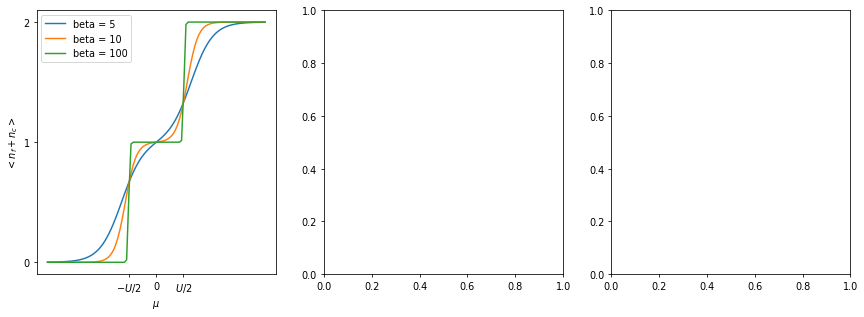

In [72]:
#calculated this by hand
def rho_in_single_site_limit(mu, beta, U):
    Z = np.exp(-beta*(U /4)) + 2*np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))  
    return 2*(np.exp(-beta*(-U /4 - mu)) + np.exp(-beta*(U /4 - 2*mu))) / Z

#A slightly more automatic way to do it
def non_symmetric_version(u, beta, U):
    Z = 0
    Nf = 0
    Nc = 0
    for nf in [0,1]:
        Ff = -U/2*(nf - 1/2) - mu*nf
        Hc = U*(nf - 1/2) - mu #Hc only has one energy level in the single site limit
        Fc = -1/beta * np.log(1 + np.exp(-beta*Hc))
        boltzman_factor = np.exp(-beta * (Fc + Ff))
        Z += boltzman_factor
        Nf += nf * boltzman_factor
        Nc += 1/(1 + np.exp(beta * Hc)) * boltzman_factor
    return Nf / Z, Nc / Z

mu = np.linspace(-2,2,100)
U = 1
f, (ax, axf,axc) = plt.subplots(1,3, figsize = (15,5))



for beta in [5, 10, 100]:
    Nf, Nc = non_symmetric_version(mu, beta=beta, U=U)
    
    ax.plot(mu, Nf + Nc, label = f'beta = {beta}')
    
    ax.set(ylabel = '$<n_f + n_c>$', xlabel = '$\mu$',
           xticks = [-1/2,0, 1/2], xticklabels = ['$-U/2$', 0, '$U/2$'], yticks = [0,1,2])
ax.legend()

## Directly evaluating the partition function for multiple sites
This iterates over all classical states and then solves the hamiltonian to evavluate the full partition function directly.

The first plot turns on hopping t with the long range interaction J set to 0.

In [20]:
def direct(system_size, mu, beta, U, J, t = 1, alpha = 1.5):
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = True, dtype = np.float64)
    
    for state in product((0,1), repeat = system_size):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)]) - muc
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

        Boltz_factor = np.exp(- beta * (Ff + Fc))
        Z += Boltz_factor
        Nf += np.sum(state) * Boltz_factor
        Nc += np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor
        Mf += np.sum(2*(state - 1/2) * A) * Boltz_factor
        M2f += np.sum(2*(state - 1/2) * A)**2 * Boltz_factor
        
    return Nf / Z, Nc / Z, Mf / Z, M2f / Z

def binder(system_size, mu, beta, U, J, t = 1, alpha = 1.5, n_cumulants = 5):
    Z = 0
    Nf = Nc = Mf = M2f = 0
    muf = muc = mu
    A = 2*(np.arange(system_size) % 2) - 1
    J_matrix = interaction_matrix(system_size, alpha, J, normalise = True, dtype = np.float64)
    
    powers = np.arange(n_cumulants)
    Mf_moments = np.zeros((2**system_size, powers.shape[0]), dtype = np.float64)
    
    BFs = np.zeros(shape = 2**system_size, dtype = np.float64)
    for i,state in enumerate(product((0,1), repeat = system_size)):
        state = np.array(state)
        if system_size > 1:
            Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)
        elif system_size == 1:
            evals = np.array([U*(state - 1/2)]) - muc
            Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
            Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

        BFs[i] = - beta * (Ff + Fc)
        #if(- beta * (Ff + Fc) > 700): print(f'- beta * (Ff + Fc) too large! : {- beta * (Ff + Fc)}')
        Mf_moments[i] = (np.sum(2*(state - 1/2) * A)/system_size)**powers
    
    BFs = BFs - np.max(BFs) + 650
    Ps = np.exp(BFs) / np.sum(np.exp(BFs))
    Mf_moments = np.sum(Mf_moments * Ps[:, None], axis = 0)

    Mf_central_moments = convert_to_central_moments(Mf_moments)
    return Mf_moments, Mf_central_moments

def compute_observables(system_size, mu, beta, U, J, t, state):
    eigenval_bins = np.linspace(-5, 5, 70 + 1)
    state = np.array(state)
    muf = muc = mu
    if system_size > 1:
        Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J, t)
    elif system_size == 1:
        evals = np.array([U*(state - 1/2)]) - muc
        Ff = - U/2*np.sum(state - 1/2) - muf*np.sum(state)
        Fc = - 1/beta * np.sum(np.log(1 + np.exp(- beta * evals)))    

    Boltz_factor = np.exp(- beta * (Ff + Fc))
    Z = Boltz_factor
    Nf = np.sum(state) * Boltz_factor
    Nc = np.sum(1 / (1 + np.exp(beta * evals))) * Boltz_factor

    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

    #these are the indices corresponding to the energy bin that each energy and IPR should go into
    hist, _, indices = index_histogram(eigenval_bins, evals)
    this_IPR_hist = np.bincount(indices, weights=IPRs, minlength = eigenval_bins.shape[0] + 1)[1:-1]

    eigenval_hist = hist * Boltz_factor
    IPR_hist = this_IPR_hist * Boltz_factor #/ np.where(hist != 0, hist, 1)

    return np.concatenate([[Z,], [Nf,], [Nc,], eigenval_hist, IPR_hist])

def direct_spectrum(system_size, mu, beta, U, J, t = 1, pool = None):
    eigenval_bins = np.linspace(-5, 5, 70 + 1)
    
    compute = functools.partial(compute_observables, system_size, mu, beta, U, J, t)
    
    if pool:
            packed_result = np.sum(pool.map(compute, product((0,1), repeat = system_size)), axis = 0)
    else:
        packed_result = np.sum(pool.map(compute, product((0,1), repeat = system_size)), axis = 0)
    
    Z, Nf, Nc, *rest = packed_result
    eigenval_hist, IPR_hist = rest[:eigenval_bins.shape[0]-1], rest[eigenval_bins.shape[0]-1:] 
        
    eigenval_hist = eigenval_hist / np.sum(eigenval_hist)
    return Nf / Z, Nc / Z, eigenval_hist, eigenval_bins, IPR_hist / Z / np.where(eigenval_hist != 0, eigenval_hist, 1)

CPU times: user 3.76 s, sys: 8 ms, total: 3.77 s
Wall time: 3.81 s


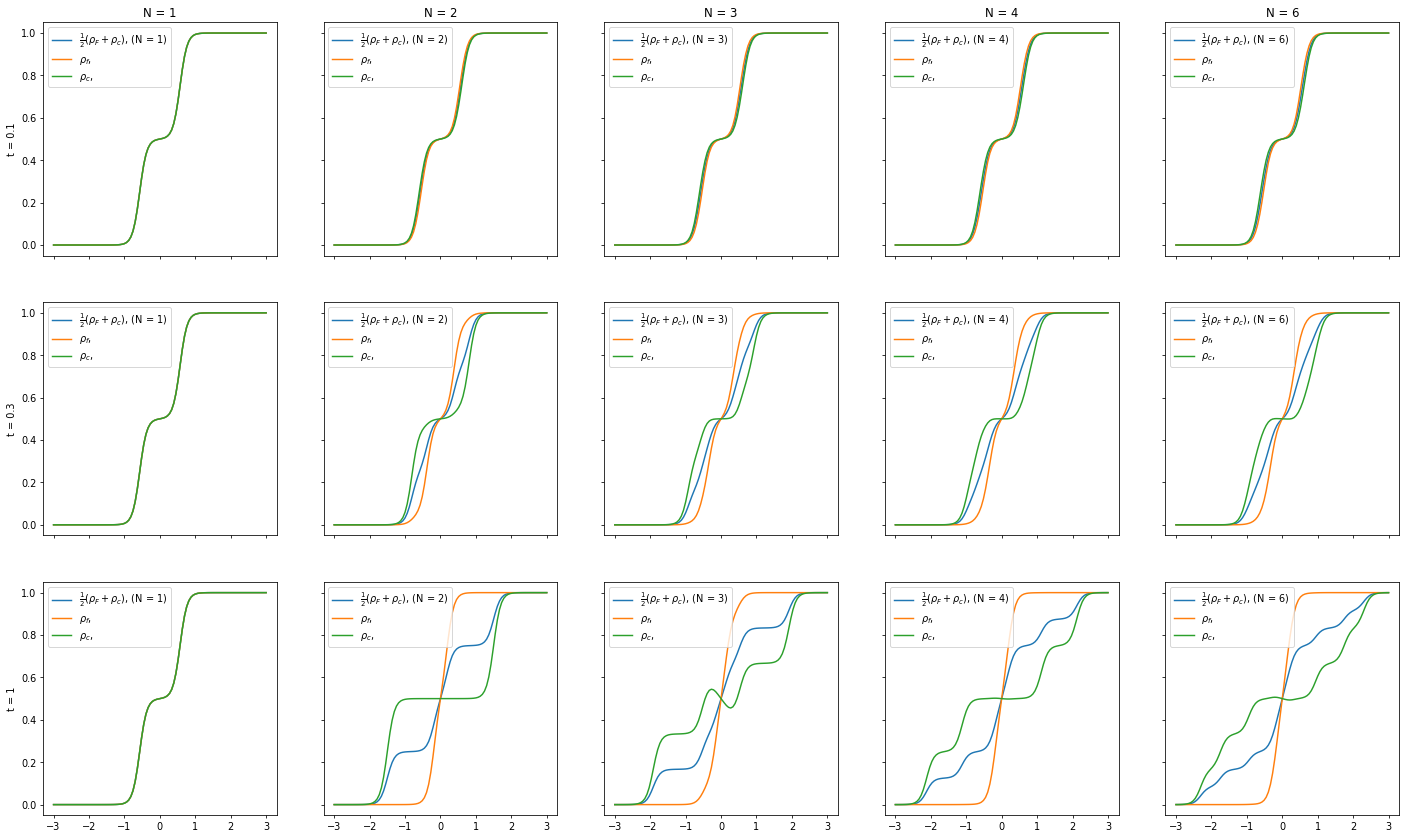

In [4]:
%%time
beta = 10
U = 1
J = 0
mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,6]
ts = [0.1, 0.3, 1]

f, axes = plt.subplots(len(ts),len(Ns),figsize = (len(Ns)*5,len(ts)*5), sharex = 'col', sharey = 'row')

for row, t in zip(axes, ts):
    for ax, N in zip(row, Ns):
        Nf, Nc, _, _ = np.array([direct(N, m, beta, U, J=J, t=t) for m in mu]).T
        Nt = (Nf + Nc)
        ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        ax.plot(mu, Nf/N, label = r'$\rho_f$,')
        ax.plot(mu, Nc/N, label = r'$\rho_c$,')
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,t in zip(axes.T[0], ts): ax.set(ylabel = f't = {t}') 

This plot turns on J with t=1 and U = 1

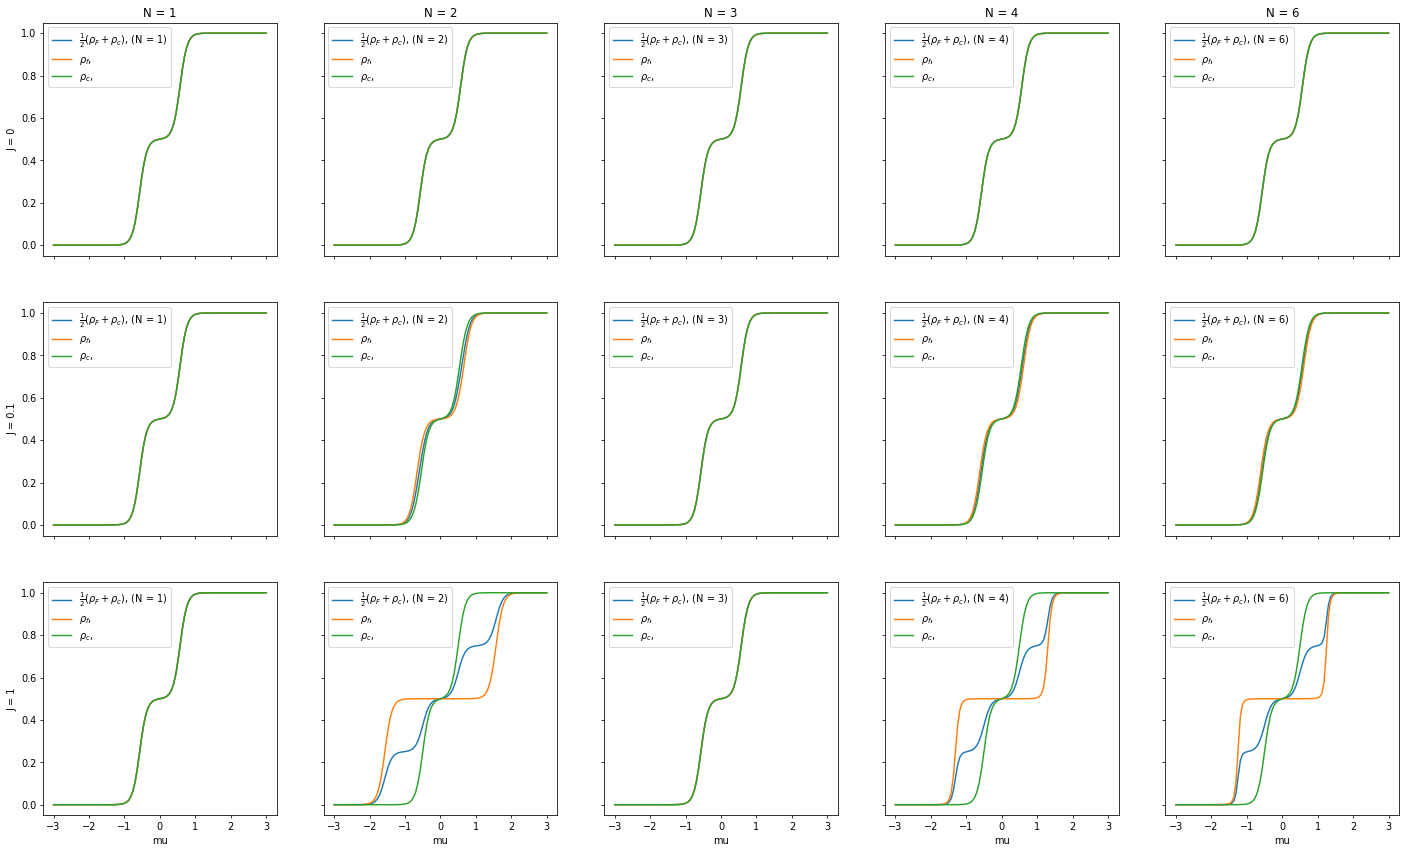

In [5]:
beta = 10
U = 1
Js = [0, 0.1, 1]
mu = np.linspace(-3,3,100)
Ns = [1,2,3,4,6]
t = 0

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')

for row, J in zip(axes, Js):
    for ax, N in zip(row, Ns):
        Nf, Nc, _, _ = np.array([direct(N, m, beta, U, J=J, t=t) for m in mu]).T
        Nt = (Nf + Nc)
        ax.plot(mu, Nt/(2*N), label = r'$\frac{1}{2}(\rho_F + \rho_c)$,' +f' (N = {N})')
        ax.plot(mu, Nf/N, label = r'$\rho_f$,')
        ax.plot(mu, Nc/N, label = r'$\rho_c$,')
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'mu') 

## Looking at the magnetisation squared

CPU times: user 10.4 s, sys: 0 ns, total: 10.4 s
Wall time: 10.4 s


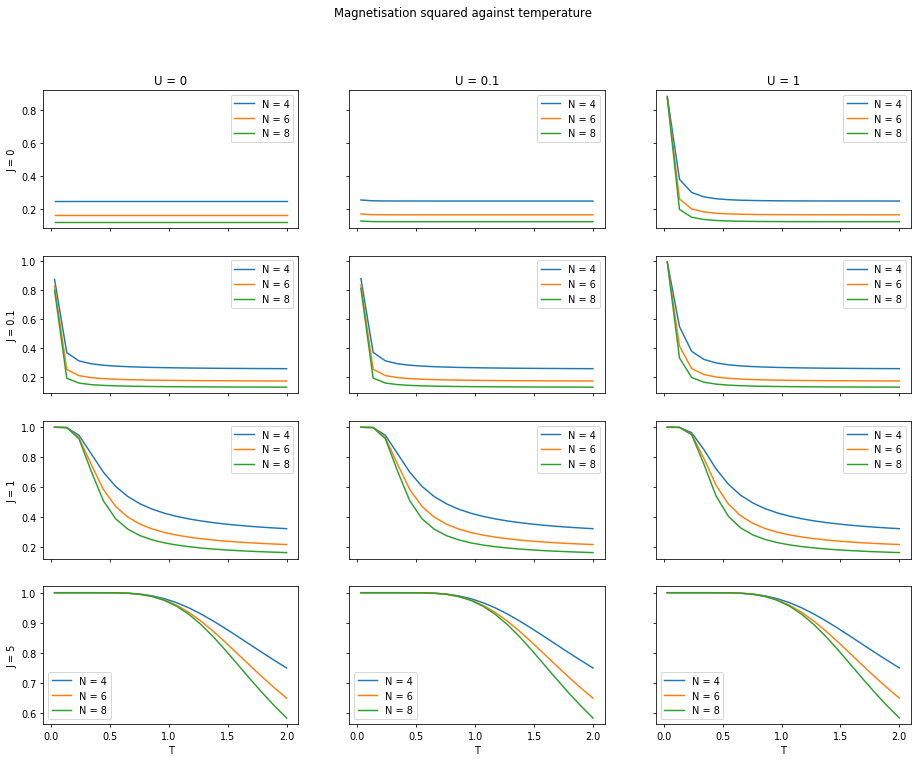

In [6]:
%%time
T = np.linspace(0.03, 2, 20)
beta = 1/T
mu = np.linspace(-3,3,100)
Ns = [4,6,8]#[6,7,8,9,10,11,12]
Us = [0,0.1,1]
Js = [0, 0.1, 1, 5]
t = 1

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row')

for row, J in zip(axes, Js):
    for ax, U in zip(row, Us):
        for system_size in Ns:
            Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = 1) for b in beta]).T
            ax.plot(T, M2f / system_size**2, label = f'N = {system_size}')
        
        ax.legend()

f.suptitle('Magnetisation squared against temperature')
for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T') 

## Looking at the Binder Cumulant

In [18]:
%%time
n_cumulants = 5
T = np.linspace(0.05, 5, 30)
beta = 1/T
Ns = [4,6,8,10,12,14,16]#[6,7,8,9,10,11,12]
Us = [0,1,10]
Js = [0, 0.1, 1, 5]
t = 1
alpha = 1.5

binder_cumulants = np.ones(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
for slice1, J in zip(binder_cumulants, Js):
    for slice2, U in zip(slice1, Us):
        for slice3, system_size in zip(slice2, Ns):
            result = np.array([binder(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t, alpha = alpha) for b in beta])
            np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_direct.npz', 
         T=T, Ns=Ns, Us=Us, Js = Js, n_cumulants=n_cumulants, t=t, alpha = alpha, beta = beta,
         binder_cumulants=binder_cumulants)

CPU times: user 1h 5min 40s, sys: 3.41 s, total: 1h 5min 44s
Wall time: 1h 2min 7s


CPU times: user 796 ms, sys: 4 ms, total: 800 ms
Wall time: 226 ms


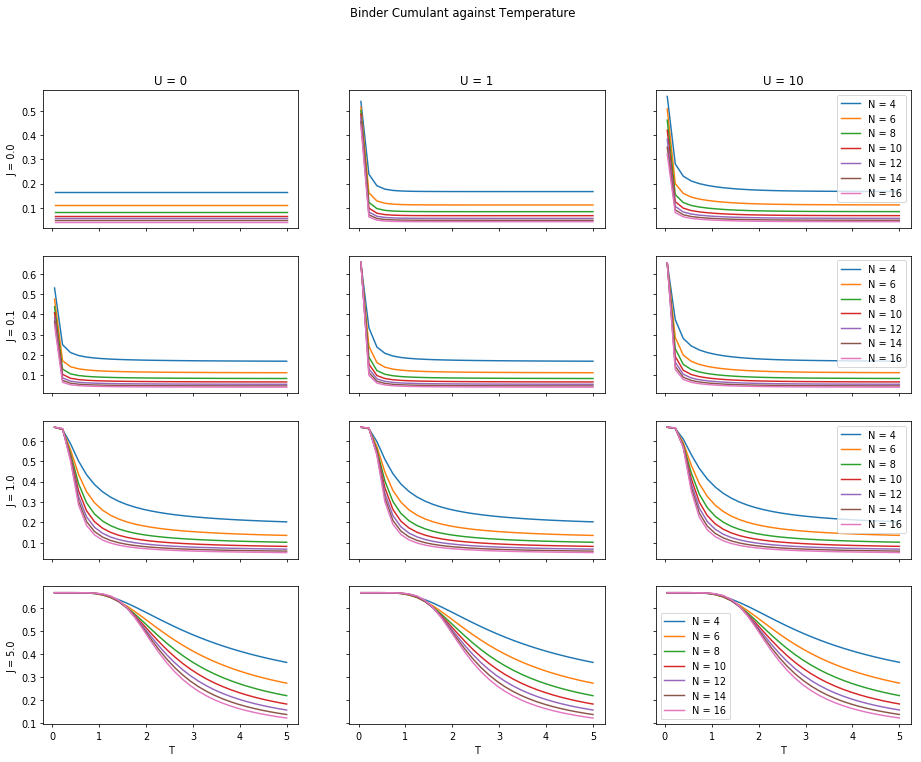

In [19]:
%%time
data = np.load('./pickled_data/binder_cumulants_direct.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row')

for row, slice1, J in zip(axes, binder_cumulants, Js):
    for ax, slice2, U in zip(row, slice1, Us):
        for slice3, system_size in zip(slice2, Ns):
            Mf_moments, Mf_central_moments = slice3
            binder_cumulant = 1 - Mf_central_moments[4]/(3*Mf_central_moments[2]**2)
            ax.plot(T, binder_cumulant, label = f'N = {system_size}')     
    ax.legend()
    
f.suptitle('Binder Cumulant against Temperature')
for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T') 

In [61]:
%%time
### redoing binder cumulants with MC
data = np.load('./pickled_data/binder_cumulants.npz')
print(list(data.keys()))
locals().update(data)
N_steps = 20
N_burn_in = 0


mcmc_binder_cumulants = np.ones(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
for slice1, J in zip(binder_cumulants, Js):
    for slice2, U in zip(slice1, Us):
        print(U, J)
        for slice3, system_size in zip(slice2, Ns):
            result = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), 
                                N_steps = N_steps, N_burn_in = N_burn_in, 
                                mu = 0, beta = b, J=J, alpha=alpha, U=U, t=t,
                                logger=Magnetisation_cumulants(N_cumulants = n_cumulants))
                               for b in beta])
            
            
            np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_mcmc.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in,
         mcmc_binder_cumulants = mcmc_binder_cumulants)

['T', 'Ns', 'Us', 'Js', 'binder_cumulants']
0.0 0.0
0.1 0.0
1.0 0.0
0.0 0.1
0.1 0.1
1.0 0.1
0.0 1.0
0.1 1.0
1.0 1.0
0.0 5.0
0.1 5.0
1.0 5.0
CPU times: user 29.1 s, sys: 4 ms, total: 29.1 s
Wall time: 29.1 s


CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 185 ms


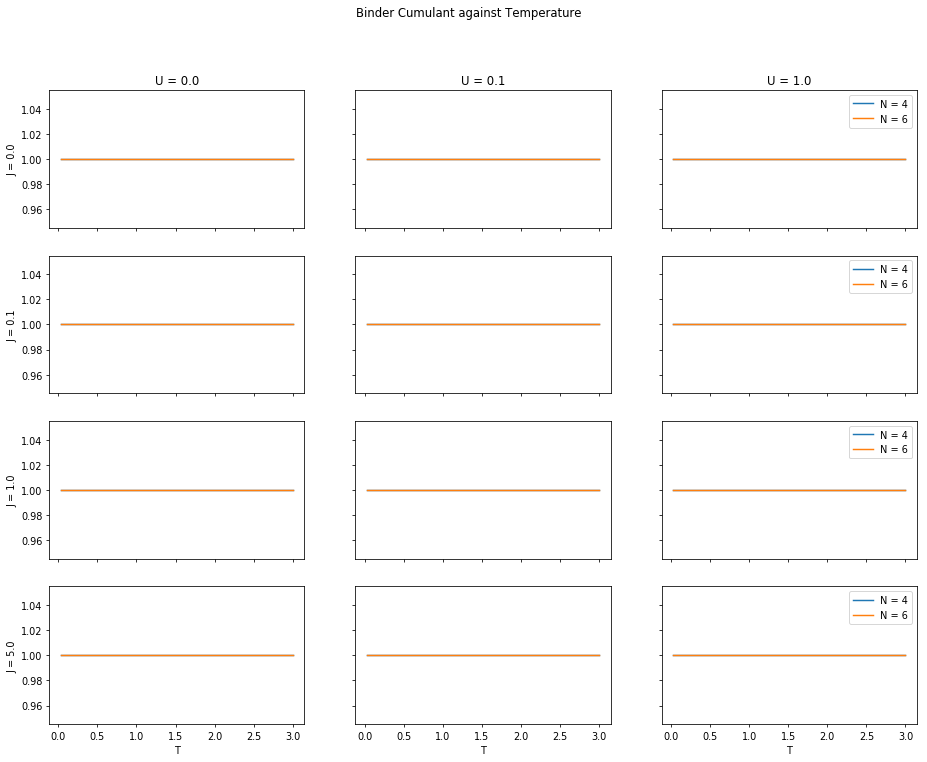

In [62]:
%%time
data = np.load('./pickled_data/binder_cumulants_direct.npz')
locals().update(data)
data = np.load('./pickled_data/binder_cumulants_mcmc.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row')

for row, slice1, J in zip(axes, mcmc_binder_cumulants, Js):
    for ax, slice2, U in zip(row, slice1, Us):
        for slice3, system_size in zip(slice2, Ns):
            Mf_moments, Mf_central_moments = slice3
            binder_cumulant = 1 - Mf_central_moments[4]/(3*Mf_central_moments[2]**2)
            #ax.plot(T, binder_cumulant, label = f'N = {system_size}')     
            ax.plot(T, Mf_moments[1], label = f'N = {system_size}')  
            
    ax.legend()
    
f.suptitle('Binder Cumulant against Temperature')
for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')

Taking the J=5, U = 1, t = 1 parameters

In [21]:
system_size = 10
J = 5
U = 1
t = 1

Ts = [0.5, 1.5, 3, 5]
colours = ['orange', 'red', 'green', 'grey']

T = np.linspace(0.05, 5, 20)
beta = 1/T

f, ax = plt.subplots()

Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = U, J = J, t = t) for b in beta]).T
ax.plot(T, M2f / system_size**2, label = f'N = {system_size}')
for T, col in zip(Ts, colours):
    Nf, Nc, Mf, M2f = direct(system_size = system_size, mu = 0, beta = 1/T, U = U, J = J, t = t)
    ax.scatter(T, M2f /system_size**2, color = col)
    
    


f, axes = plt.subplots(2,len(Ts), figsize = (7*len(Ts),7))

for T, colour, (hax, iax) in zip(Ts, colours, axes.T):
    J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
    
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/T, U = 1, J = J_matrix, t = 1. pool=pool)
    hax.plot(eigenval_bins[:-1], eigenval_hist, color = colour, label = f"T = {T}")
    iax.plot(eigenval_bins[:-1], IPR_hist, color = colour)
    
    hax.legend()

SyntaxError: invalid syntax (<ipython-input-21-7c8c96facd31>, line 29)

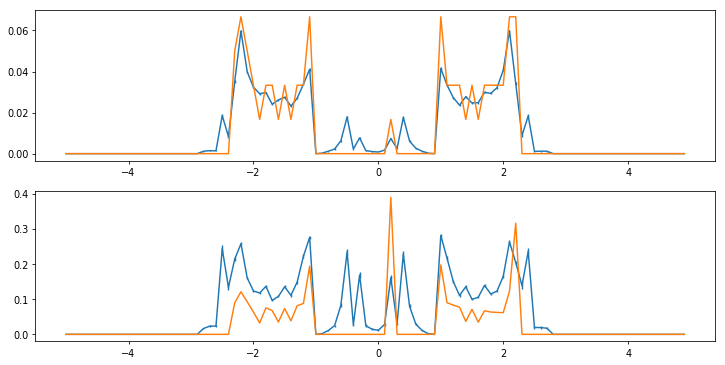

In [90]:
class Eigenspectrum_IPR(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)

    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)
        self.eigenval_histogram[j], _, indices = index_histogram(self.eigenval_bins, evals)
        self.IPR_histogram[j] = np.bincount(indices, weights=IPRs, minlength = self.eigenval_bins.shape[0] + 1)[1:-1]

    
    def return_vals(self):
        E_histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(E_histogram)
        
        E_histogram = E_histogram / normalisation_factor 
        dE_histogram = scipy.stats.sem(self.eigenval_histogram, axis = 0) / normalisation_factor
        
        IPR_histogram, dIPR_histogram = np.mean(self.IPR_histogram, axis = 0), scipy.stats.sem(self.IPR_histogram, axis = 0)
        
        return self.eigenval_bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram

f,(Eax,Iax) = plt.subplots(2, figsize = (2*textwidth, textwidth))

system_size = 60
for J in [0,1]:
    bins, E_histogram, dE_histogram, IPR_histogram, dIPR_histogram = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 500, N_burn_in = 10, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum_IPR(bins = 100)) 
    Eax.errorbar(bins[:-1], E_histogram, yerr = dE_histogram, label = f'J = {J}')
    Iax.errorbar(bins[:-1], IPR_histogram, yerr = dIPR_histogram, label = f'J = {J}')
ax.legend()

CPU times: user 5.18 s, sys: 2.05 s, total: 7.22 s
Wall time: 49.5 s


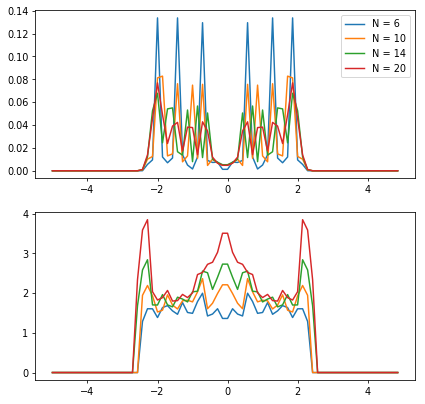

In [79]:
system_size = 12
J = 5
U = 1
t = 1
T = 1.5
Ns = [6,10,14,20]

f, (hax, iax) = plt.subplots(2, figsize = (7,7))
for system_size in Ns:
    J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
    Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/T, U = U, J = J_matrix, t = t)
    hax.plot(eigenval_bins[:-1], eigenval_hist, label = f'N = {system_size}')
    iax.plot(eigenval_bins[:-1], IPR_hist)
    
hax.legend()

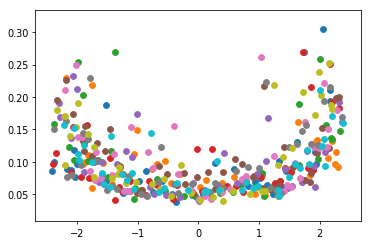

In [131]:
muc = 0
muf = 0
mu = 0
beta = 10
J = 1
U = 1
t = 1
N = 40

for _ in range(10):
    state = np.random.choice((0,1), N)
    J_matrix = interaction_matrix(N, alpha = 1.5, J = J, normalise = True, dtype = np.float64)

    Ff, Fc, evals, evecs = solve_H(state, mu, beta, U, J_matrix, t)  

    Boltz_factor = np.exp(- beta * (Ff + Fc))

    IPRs = ((evecs * np.conj(evecs))**2).sum(axis = 0)

    #these are the indices corresponding to the energy bin that each energy and IPR should go into
    hist, _, indices = index_histogram(eigenval_bins, evals)
    this_IPR_hist = np.bincount(indices, weights=IPRs, minlength = eigenval_bins.shape[0] + 1)[1:-1]

    plt.scatter(evals, IPRs)

CPU times: user 21 s, sys: 0 ns, total: 21 s
Wall time: 21 s


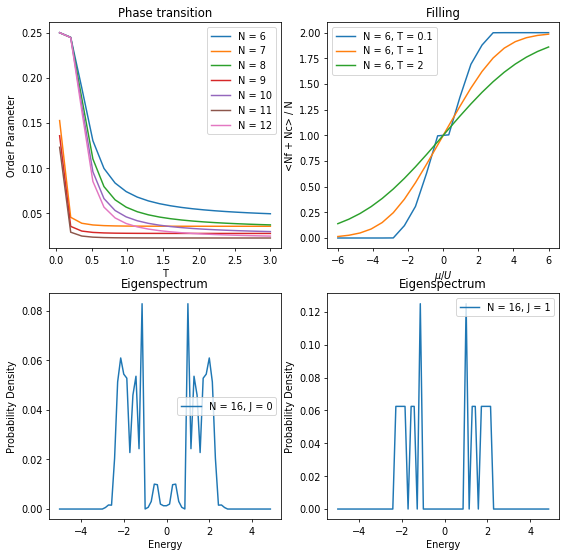

In [45]:
%%time
f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()
T = np.linspace(0.05, 3, 20)
beta = 1/T

#for system_size in [6]:
for system_size in [6,7,8,9,10,11,12]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}')
    
mu = np.linspace(-6, 6, 20)
system_size = 6
for T in [0.1,1,2]:
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}')
    
    
for J in [0,1]:
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}')
    
axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy')

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/direct_partition_function.eps")

In [32]:
class Eigenspectrum(object):
    def __init__(self, bins = 70, limit = 5):
        self.eigenval_bins = np.linspace(-limit, limit, bins + 1)
    
    def start(self, N_steps, N_sites):
        self.N_steps = N_steps
        self.eigenvals = np.zeros((N_steps,N_sites), dtype = np.float64)
        self.eigenval_histogram = np.zeros((N_steps,self.eigenval_bins.shape[0]-1), dtype = np.float64)
        self.IPR_histogram = np.zeros(eigenval_bins.shape[0]-1, dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.eigenval_histogram[j] = np.histogram(evals, self.eigenval_bins)[0]
    
    def return_vals(self):
        bins = self.eigenval_bins
        histogram = np.mean(self.eigenval_histogram, axis = 0)
        normalisation_factor = np.sum(histogram)
        histogram = histogram / normalisation_factor 
        dhistogram = np.std(self.eigenval_histogram, axis = 0) / normalisation_factor / np.sqrt(self.N_steps)
        return bins, histogram, dhistogram

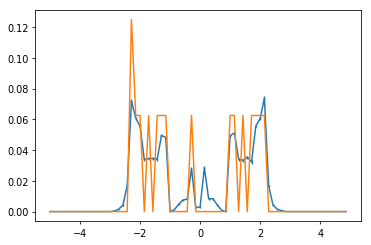

In [33]:
eigens_mcmc = np.zeros((2,70), dtype = np.float64)
deigens_mcmc = np.zeros((2,70), dtype = np.float64)
system_size = 16
for J in [0,1]:
    eigenval_bins, eigenval_hist, deigenval_hist = FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = 1000, N_burn_in = 200, mu = 0, beta = 1/0.07, U = 2, J=J, alpha=1.5, t = 1,
                                  logger=Eigenspectrum()) 
        
    eigens_mcmc[J] = eigenval_hist
    deigens_mcmc[J] = deigenval_hist
    plt.errorbar(eigenval_bins[:-1], eigenval_hist, yerr = deigenval_hist)

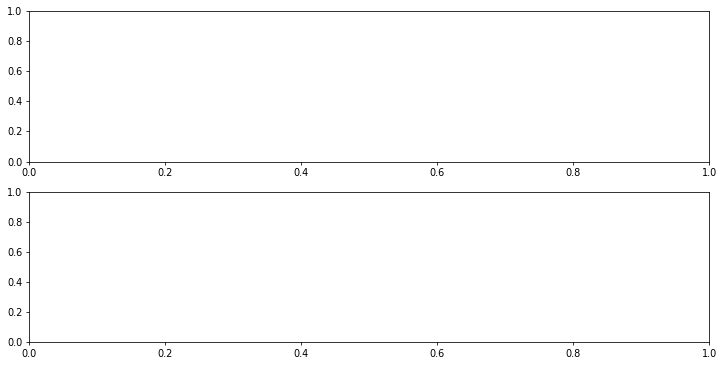

NameError: name 'eigenval_bins' is not defined

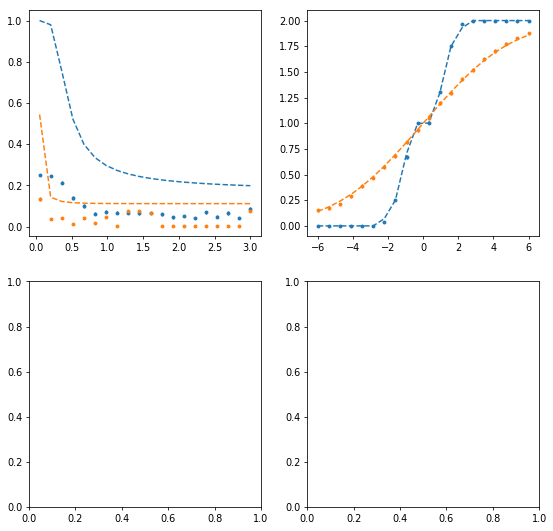

In [66]:
f,axs = plt.subplots(2,2,figsize = (textwidth*1.5,textwidth*1.5))
axs = axs.flatten()

#plot magnetisation as a function of T
class Magnetisation_squared(object):
    def start(self, N_steps, N_sites):
        self.A = 2*(np.arange(system_size) % 2) - 1
        self.M2f = np.zeros((N_steps), dtype = np.float64).T
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.M2f[j] = np.sum((state - 1/2) * self.A)**2
    
    def return_vals(self):
        return np.mean(self.M2f), np.std(self.M2f) / np.sqrt(self.M2f.shape[0])
    
class Density(object):
    def start(self, N_steps, N_sites):
        self.N = np.zeros((N_steps), dtype = np.float64)
    
    def update(self, j, Ff, Fc, state, evals, evecs, mu, beta, J_matrix):
        self.N[j] = np.sum(state) + np.sum(1/(1 + np.exp(beta * evals)))
    
    def return_vals(self):
        return np.mean(self.N), np.std(self.N) / np.sqrt(self.N.shape[0])

N_burn_in = 50
N_steps = 100
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = np.linspace(0.05, 3, 20)
beta = 1/T
system_sizes = [6,9]


for system_size,color in zip(system_sizes, colors):
#for system_size in [6,7,8,9,10,11,12]:
    _, _, Mf, M2f = np.array([direct(system_size = system_size, mu = 0, beta = b, U = 1, J = 1, t = 1) for b in beta]).T
    axs[0].plot(T, M2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '--')
    
    M2f, dM2f = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = 0, beta = b, J=1, alpha=1.5, U = 1,
                                  logger=Magnetisation_squared()) for b in beta]).T
    axs[0].errorbar(T, M2f / system_size**2, yerr= dM2f / system_size**2, label = f'N = {system_size}', color = color, linestyle = '', marker = '.')

    
mu = np.linspace(-6, 6, 20)
system_size = 4
Ts = [0.1,2]

for T,color in zip(Ts, colors):
    Nf, Nc, Mf, M2f = np.array([direct(system_size = system_size, mu = m, beta = 1/T, U = 1, J = 1, t = 1) for m in mu]).T
    axs[1].plot(mu, (Nf+Nc)/system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '--')
    
    N, dN = np.array([FK_mcmc(state=np.random.choice([0,1],system_size), N_steps = N_steps, N_burn_in = N_burn_in, mu = m, beta = 1/T, J=1, alpha=1.5, U = 1,
                                  logger=Density()) for m in mu]).T
    axs[1].errorbar(mu, N / system_size, yerr = dN / system_size, label = f'N = {system_size}, T = {T}', color = color, linestyle = '', marker = '.')
    

for J,color in zip([0,1],colors):
    axs[2+J].plot(eigenval_bins[:-1], eigens[J], label = f'N = 16, J = {J}', color = color)
    axs[2+J].errorbar(eigenval_bins[:-1], eigens_mcmc[J], yerr = deigens_mcmc[J], label = f'N = 16, J = {J}', marker = '.', linestyle = '', color = color)

axs[0].set(title = 'Phase transition', ylabel = 'Order Parameter', xlabel = 'T')
axs[1].set(title = 'Filling', ylabel = '<Nf + Nc> / N', xlabel = '$\mu / U$')
axs[2].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))
axs[3].set(title = 'Eigenspectrum', ylabel = 'Probability Density', xlabel = 'Energy', xlim = (-3,3))

for ax in axs: ax.legend()
f.savefig("/home/tch14/workspace/fake_home/Dropbox/Apps/Overleaf/Notes for Jo May '19/mcmc_partition_function.eps")

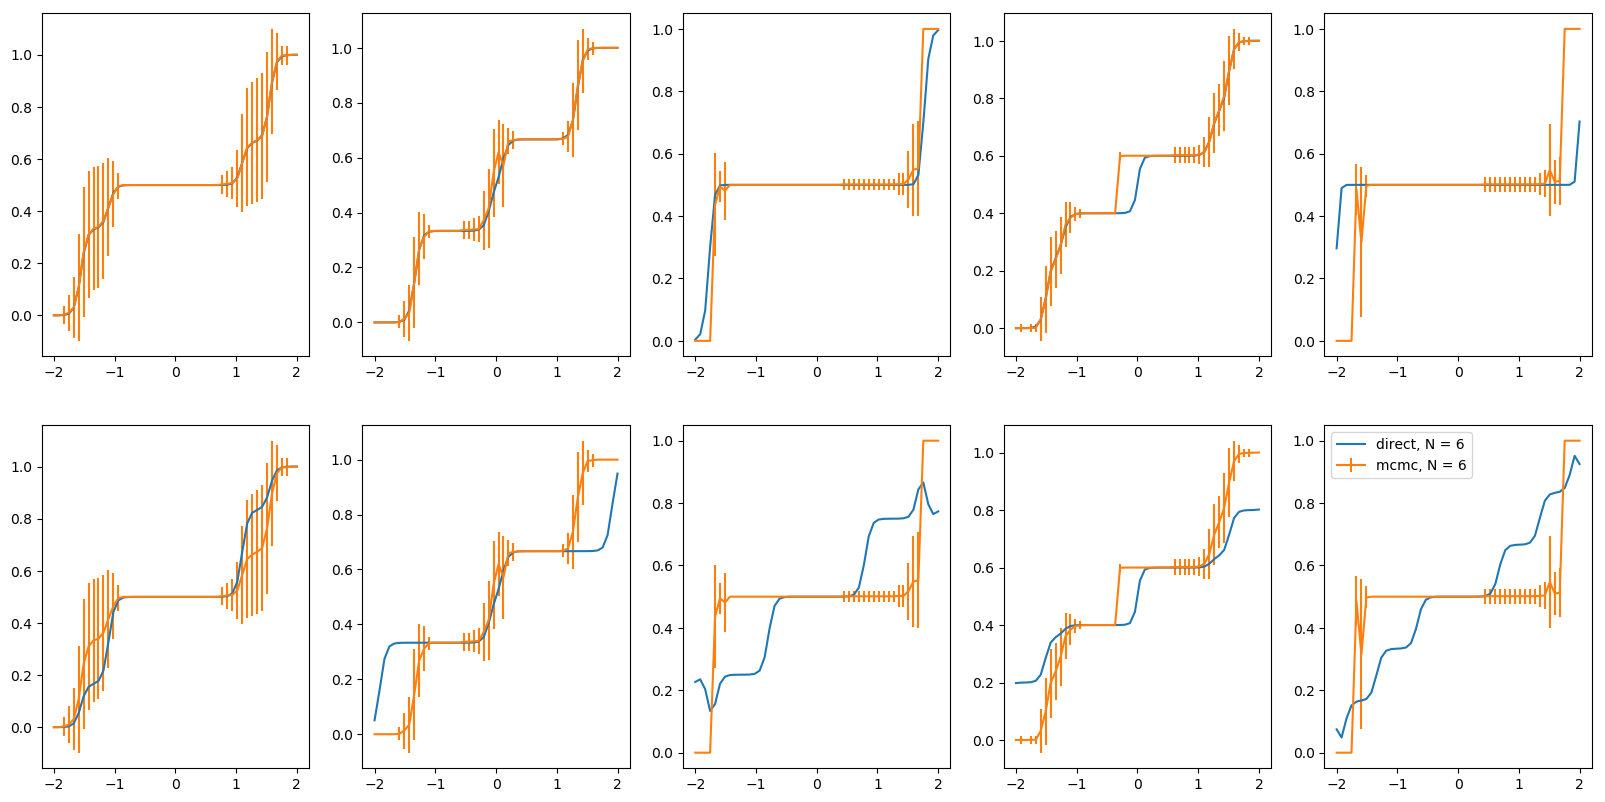

In [123]:
beta = 20
U = 1
mu = np.linspace(-2,2,50)
N_steps = 200
alpha = 1.5
J = 1

Ns = np.arange(2,7)
f, axes = plt.subplots(2, len(Ns), figsize = (20,10))

for (axf,axc),N in zip(axes.T,Ns):
    J_matrix = interaction_matrix(N, alpha, J=J, normalise = True, dtype = np.float64)
    Nf, Nc = np.array([direct_N(N, m, beta, U, J=J_matrix) for m in mu]).T
    Nt = (Nf + Nc) / N
    axf.plot(mu, Nf / N, label = f'direct, N = {N}')
    axc.plot(mu, Nc / N, label = f'direct, N = {N}')
    

    Nf, dNf, Nc, dNc = np.zeros((4,mu.shape[0]), dtype = np.float64)
    for i,m in enumerate(mu):
        state = np.zeros(N, dtype = np.float64)
        
        log = FK_mcmc(
        state,            
        N_steps = N_steps, N_burn_in = 0,
        mu = m, beta = beta, J=J, alpha=alpha, U = U
        )  
        
        Nf[i] = np.mean(log.Nf) / (N)
        dNf[i] = np.std(log.Nf) / (N)
        Nc[i] = np.mean(log.Nf) / (N)
        dNc[i] = np.std(log.Nf) / (N)
    
    axf.errorbar(mu, Nf, yerr = dNf, label = f'mcmc, N = {N}')
    axc.errorbar(mu, Nc, yerr = dNc, label = f'mcmc, N = {N}')
    
plt.legend()
#plt.savefig()

In [15]:
import scipy.stats
x = np.random.normal(loc = 1, scale = 2, size = int(1e4))
np.mean(x), np.std(x), np.std(x) / np.sqrt(len(x)), scipy.stats.sem(x)

(0.9840366332071342,
 2.0113960506839215,
 0.020113960506839213,
 0.020114966280298196)

In [ ]:
J_matrix = interaction_matrix(system_size, alpha = 1.5, J = J, normalise = True, dtype = np.float64)
Nf, Nc, eigenval_hist, eigenval_bins, IPR_hist = direct_spectrum(system_size, mu = 0, beta = 1/1.5, U = 1, J = J_matrix, t = 1)

In [ ]:
plt.plot(eigenval_bins, eigenval_hist)